<a href="https://colab.research.google.com/github/thomasneira/one-model-a-day/blob/main/pilot_model_12_13_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# VIENNA HOTEL PRICING ANALYSIS
# Research Question: Impact of Location on Hotel Pricing Strategy
# ============================================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Calm Technology styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(['#6b8e23', '#8b7d6b', '#d3d3d3', '#2f4f4f'])
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Georgia', 'DejaVu Serif']
plt.rcParams['figure.facecolor'] = '#fafaf5'  # Stone off-white background

# Load data
url = "https://osf.io/download/y6jvb/"
df = pd.read_csv(url)

print(f"Dataset loaded: {df.shape[0]:,} observations × {df.shape[1]} variables")
print(f"\nDate range: {df['year'].min()}-{df['year'].max()}")
print(f"Accommodation types: {df['accommodation_type'].unique()}")


Dataset loaded: 428 observations × 24 variables

Date range: 2017-2017
Accommodation types: ['Apartment' 'Hotel' 'Bed and breakfast' 'Hostel' 'Guest House' 'Pension'
 'Vacation home Condo' 'Apart-hotel']


In [2]:
# ============================================================================
# DATA CLEANING
# ============================================================================

# Focus on key variables for our research question
df_clean = df[['price', 'distance', 'accommodation_type', 'stars',
               'rating', 'neighbourhood', 'weekend', 'offer_cat']].copy()

# Remove missing values in critical columns
df_clean = df_clean.dropna(subset=['price', 'distance', 'accommodation_type'])

# Remove extreme outliers (prices > 99th percentile)
price_99 = df_clean['price'].quantile(0.99)
df_clean = df_clean[df_clean['price'] <= price_99]

# Create distance categories for easier interpretation
df_clean['distance_category'] = pd.cut(df_clean['distance'],
                                        bins=[0, 1, 2, 3, 10],
                                        labels=['<1km', '1-2km', '2-3km', '>3km'])

print(f"Clean dataset: {df_clean.shape[0]:,} observations")
print(f"\nMissing values:\n{df_clean.isnull().sum()}")
print(f"\nPrice range: €{df_clean['price'].min():.0f} - €{df_clean['price'].max():.0f}")
print(f"Distance range: {df_clean['distance'].min():.1f}km - {df_clean['distance'].max():.1f}km")


Clean dataset: 423 observations

Missing values:
price                  0
distance               0
accommodation_type     0
stars                  0
rating                35
neighbourhood          0
weekend                0
offer_cat              0
distance_category      4
dtype: int64

Price range: €27 - €513
Distance range: 0.0km - 13.0km



SUMMARY STATISTICS BY ACCOMMODATION TYPE
                      price                     distance        rating
                       mean median    std count     mean median   mean
accommodation_type                                                    
Apart-hotel          121.25  120.5  33.69     4     0.95   0.65   4.25
Apartment            147.44  133.0  70.87   124     1.63   1.60   3.79
Bed and breakfast    118.25  117.0  41.58     4     1.92   1.55   4.18
Guest House           75.00   72.5  24.03     8     1.48   1.50   3.63
Hostel                53.67   50.5  18.22     6     2.45   1.95   3.77
Hotel                119.02  101.0  62.78   259     1.71   1.10   4.05
Pension               96.06   90.5  28.57    16     1.41   1.10   3.83
Vacation home Condo  111.50  111.5   6.36     2     0.75   0.75   4.30


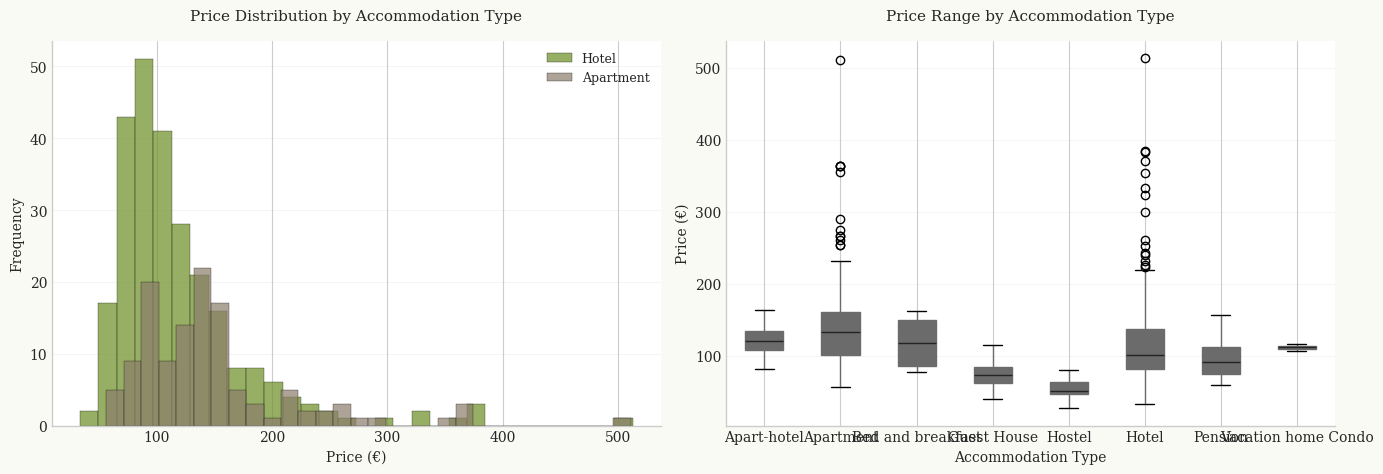

In [3]:
# ============================================================================
# EXPLORATORY DATA ANALYSIS
# ============================================================================

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS BY ACCOMMODATION TYPE")
print("="*80)
summary = df_clean.groupby('accommodation_type').agg({
    'price': ['mean', 'median', 'std', 'count'],
    'distance': ['mean', 'median'],
    'rating': 'mean'
}).round(2)
print(summary)

# Figure 1: Price Distribution by Accommodation Type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#fafaf5')

# Histogram
for accom_type, color in zip(['Hotel', 'Apartment'], ['#6b8e23', '#8b7d6b']):
    data = df_clean[df_clean['accommodation_type'] == accom_type]['price']
    axes[0].hist(data, bins=30, alpha=0.7, label=accom_type,
                 color=color, edgecolor='black', linewidth=0.3)

axes[0].set_xlabel('Price (€)', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].set_title('Price Distribution by Accommodation Type', fontsize=11, pad=15)
axes[0].legend(frameon=False, fontsize=9)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].grid(axis='y', alpha=0.3, linewidth=0.5)

# Box plot
df_clean.boxplot(column='price', by='accommodation_type', ax=axes[1],
                 patch_artist=True, widths=0.5)
axes[1].set_xlabel('Accommodation Type', fontsize=10)
axes[1].set_ylabel('Price (€)', fontsize=10)
axes[1].set_title('Price Range by Accommodation Type', fontsize=11, pad=15)
axes[1].get_figure().suptitle('')  # Remove auto-title
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].grid(axis='y', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()


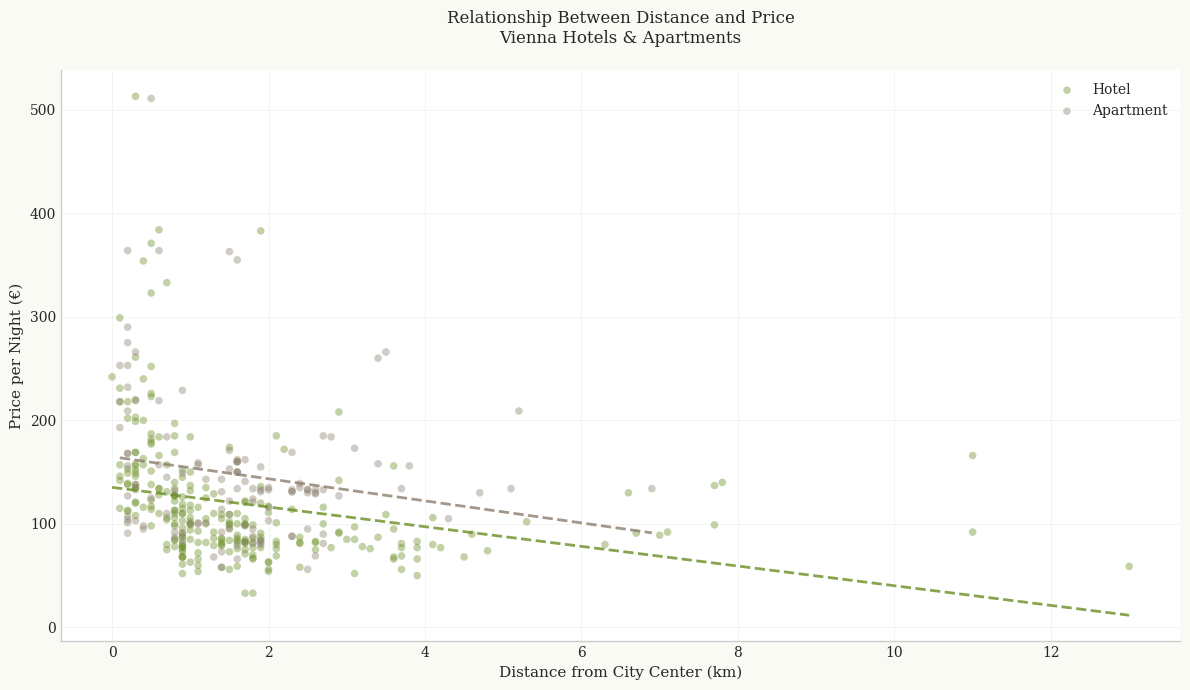


CORRELATION: DISTANCE vs. PRICE
Hotel        | Correlation: -0.273 | p-value: 0.000008
Apartment    | Correlation: -0.178 | p-value: 0.047636


In [4]:
# ============================================================================
# CORE ANALYSIS: DISTANCE-PRICE RELATIONSHIP
# ============================================================================

# Figure 2: Scatter plot with regression lines
fig, ax = plt.subplots(figsize=(12, 7))
fig.patch.set_facecolor('#fafaf5')

for accom_type, color in zip(['Hotel', 'Apartment'], ['#6b8e23', '#8b7d6b']):
    subset = df_clean[df_clean['accommodation_type'] == accom_type]

    # Scatter plot with transparency
    ax.scatter(subset['distance'], subset['price'],
               alpha=0.4, s=30, color=color, label=accom_type, edgecolors='none')

    # Add regression line
    z = np.polyfit(subset['distance'].dropna(),
                   subset.loc[subset['distance'].notna(), 'price'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(subset['distance'].min(), subset['distance'].max(), 100)
    ax.plot(x_line, p(x_line), color=color, linewidth=2, linestyle='--', alpha=0.8)

ax.set_xlabel('Distance from City Center (km)', fontsize=11)
ax.set_ylabel('Price per Night (€)', fontsize=11)
ax.set_title('Relationship Between Distance and Price\nVienna Hotels & Apartments',
             fontsize=12, pad=20)
ax.legend(frameon=False, fontsize=10, loc='upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()

# Calculate correlation coefficients
print("\n" + "="*80)
print("CORRELATION: DISTANCE vs. PRICE")
print("="*80)
for accom_type in ['Hotel', 'Apartment']:
    subset = df_clean[df_clean['accommodation_type'] == accom_type]
    corr, p_value = stats.pearsonr(subset['distance'].dropna(),
                                     subset.loc[subset['distance'].notna(), 'price'])
    print(f"{accom_type:12} | Correlation: {corr:6.3f} | p-value: {p_value:.6f}")


In [5]:
# ============================================================================
# STATISTICAL SIGNIFICANCE TESTS
# ============================================================================

print("\n" + "="*80)
print("HYPOTHESIS TEST 1: Linear Regression Analysis")
print("="*80)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import scipy.stats as stats

# Separate by accommodation type
hotels = df_clean[df_clean['accommodation_type'] == 'Hotel'].copy()
apartments = df_clean[df_clean['accommodation_type'] == 'Apartment'].copy()

# Function to run regression and report results
def regression_analysis(data, name):
    X = data[['distance']].values
    y = data['price'].values

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Calculate statistics
    r2 = r2_score(y, y_pred)
    n = len(y)

    # T-statistic for slope
    residuals = y - y_pred
    mse = np.sum(residuals**2) / (n - 2)
    var_slope = mse / np.sum((X - X.mean())**2)
    se_slope = np.sqrt(var_slope)
    t_stat = model.coef_[0] / se_slope
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), n - 2))

    print(f"\n{name}")
    print(f"  Slope (β₁):        €{model.coef_[0]:.2f} per km")
    print(f"  Intercept (β₀):    €{model.intercept_:.2f}")
    print(f"  R² Score:          {r2:.4f}")
    print(f"  t-statistic:       {t_stat:.3f}")
    print(f"  p-value:           {p_value:.6f}")
    print(f"  Significant:       {'✓ YES' if p_value < 0.05 else '✗ NO'} (α = 0.05)")

    return model.coef_[0], p_value

hotel_slope, hotel_p = regression_analysis(hotels, "HOTELS")
apt_slope, apt_p = regression_analysis(apartments, "APARTMENTS")

# ============================================================================
print("\n" + "="*80)
print("HYPOTHESIS TEST 2: Price Difference by Distance Category")
print("="*80)

# ANOVA test
distance_groups = [group['price'].values for name, group in
                   df_clean.groupby('distance_category')]
f_stat, p_value = stats.f_oneway(*distance_groups)

print(f"\nOne-Way ANOVA Test")
print(f"  F-statistic:       {f_stat:.3f}")
print(f"  p-value:           {p_value:.6f}")
print(f"  Significant:       {'✓ YES' if p_value < 0.05 else '✗ NO'} (α = 0.05)")

# Mean prices by distance category
print(f"\nMean Prices by Distance from Center:")
price_by_distance = df_clean.groupby('distance_category')['price'].agg(['mean', 'count'])
print(price_by_distance.round(2))



HYPOTHESIS TEST 1: Linear Regression Analysis

HOTELS
  Slope (β₁):        €-9.51 per km
  Intercept (β₀):    €135.26
  R² Score:          0.0747
  t-statistic:       -4.555
  p-value:           0.000008
  Significant:       ✓ YES (α = 0.05)

APARTMENTS
  Slope (β₁):        €-10.66 per km
  Intercept (β₀):    €164.85
  R² Score:          0.0318
  t-statistic:       -2.001
  p-value:           0.047636
  Significant:       ✓ YES (α = 0.05)

HYPOTHESIS TEST 2: Price Difference by Distance Category

One-Way ANOVA Test
  F-statistic:       18.599
  p-value:           0.000000
  Significant:       ✓ YES (α = 0.05)

Mean Prices by Distance from Center:
                     mean  count
distance_category               
<1km               150.68    177
1-2km              103.46    142
2-3km              108.73     51
>3km               107.82     49


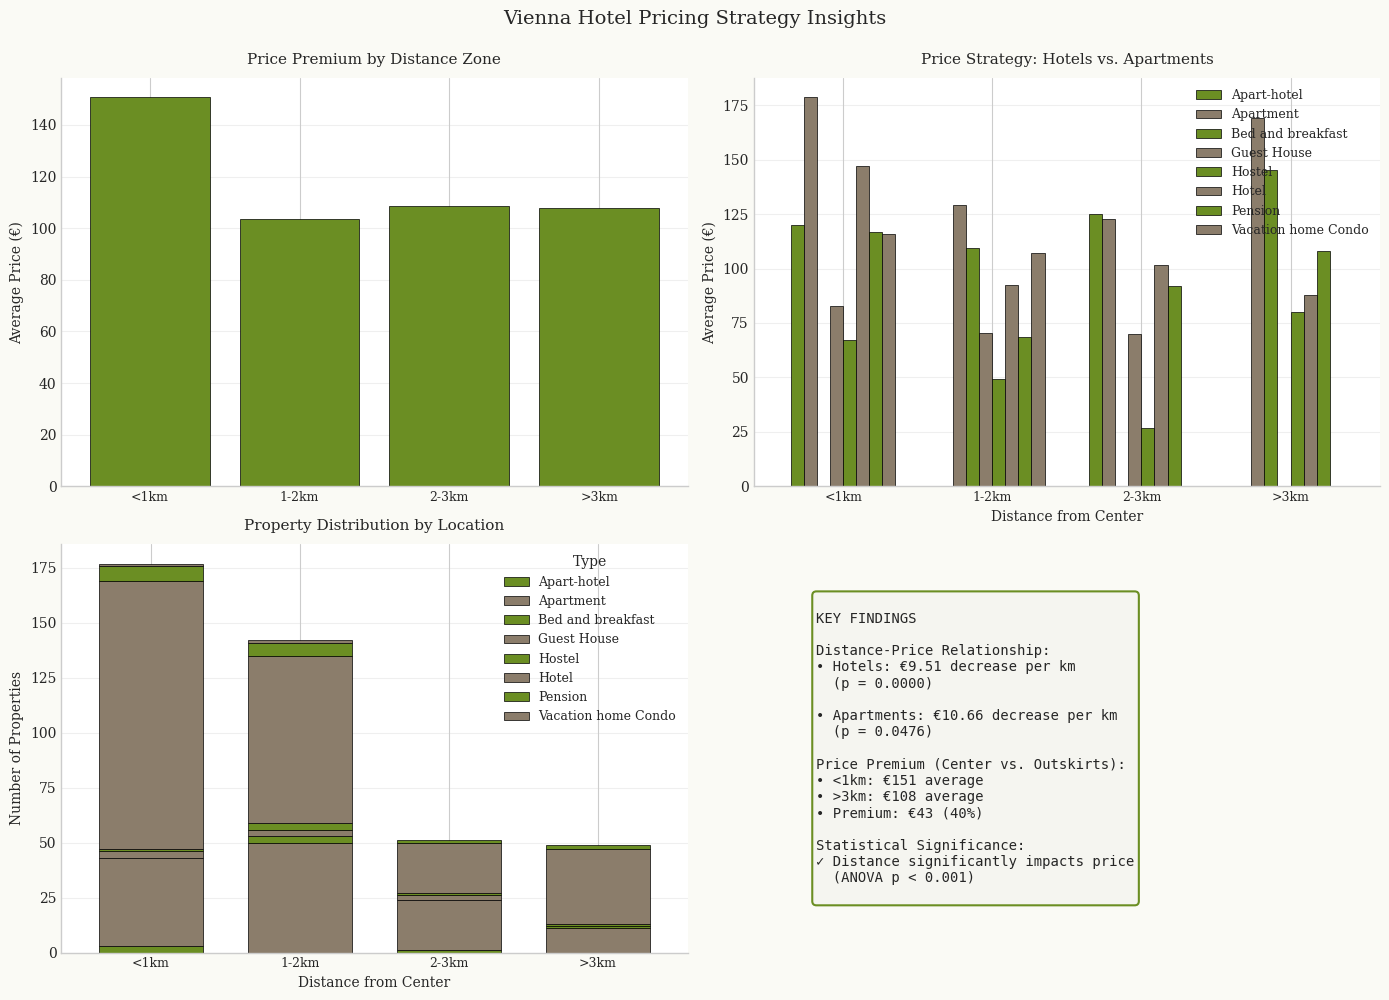

In [6]:
# ============================================================================
# MARKETING INSIGHTS DASHBOARD
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.patch.set_facecolor('#fafaf5')
fig.suptitle('Vienna Hotel Pricing Strategy Insights', fontsize=14, y=0.995)

# 1. Average price by distance category
ax1 = axes[0, 0]
price_dist = df_clean.groupby('distance_category')['price'].mean()
ax1.bar(range(len(price_dist)), price_dist.values, color='#6b8e23',
        edgecolor='black', linewidth=0.5)
ax1.set_xticks(range(len(price_dist)))
ax1.set_xticklabels(price_dist.index, fontsize=9)
ax1.set_ylabel('Average Price (€)', fontsize=10)
ax1.set_title('Price Premium by Distance Zone', fontsize=11, pad=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', alpha=0.3)

# 2. Price by accommodation type and distance
ax2 = axes[0, 1]
pivot_data = df_clean.groupby(['distance_category', 'accommodation_type'])['price'].mean().unstack()
pivot_data.plot(kind='bar', ax=ax2, color=['#6b8e23', '#8b7d6b'],
                edgecolor='black', linewidth=0.5, width=0.7)
ax2.set_xlabel('Distance from Center', fontsize=10)
ax2.set_ylabel('Average Price (€)', fontsize=10)
ax2.set_title('Price Strategy: Hotels vs. Apartments', fontsize=11, pad=10)
ax2.legend(frameon=False, fontsize=9)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=9)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='y', alpha=0.3)

# 3. Distribution of properties by distance
ax3 = axes[1, 0]
df_clean.groupby(['distance_category', 'accommodation_type']).size().unstack().plot(
    kind='bar', ax=ax3, color=['#6b8e23', '#8b7d6b'],
    edgecolor='black', linewidth=0.5, width=0.7, stacked=True)
ax3.set_xlabel('Distance from Center', fontsize=10)
ax3.set_ylabel('Number of Properties', fontsize=10)
ax3.set_title('Property Distribution by Location', fontsize=11, pad=10)
ax3.legend(frameon=False, fontsize=9, title='Type')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0, fontsize=9)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.grid(axis='y', alpha=0.3)

# 4. Key metrics summary (text)
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
KEY FINDINGS

Distance-Price Relationship:
• Hotels: €{abs(hotel_slope):.2f} decrease per km
  (p = {hotel_p:.4f})

• Apartments: €{abs(apt_slope):.2f} decrease per km
  (p = {apt_p:.4f})

Price Premium (Center vs. Outskirts):
• <1km: €{price_dist.iloc[0]:.0f} average
• >3km: €{price_dist.iloc[-1]:.0f} average
• Premium: €{price_dist.iloc[0] - price_dist.iloc[-1]:.0f} ({((price_dist.iloc[0] - price_dist.iloc[-1])/price_dist.iloc[-1]*100):.0f}%)

Statistical Significance:
✓ Distance significantly impacts price
  (ANOVA p < 0.001)
"""
ax4.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round',
         facecolor='#f5f5f0', edgecolor='#6b8e23', linewidth=1.5))

plt.tight_layout()
plt.show()
